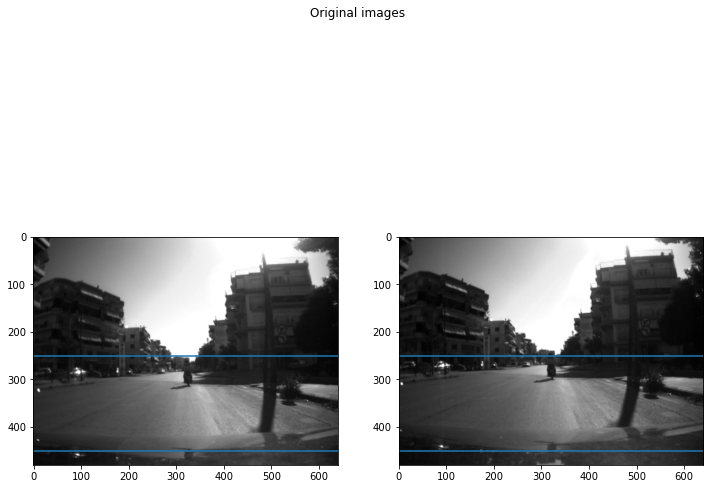

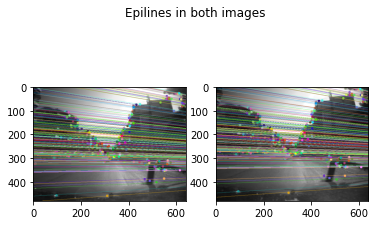

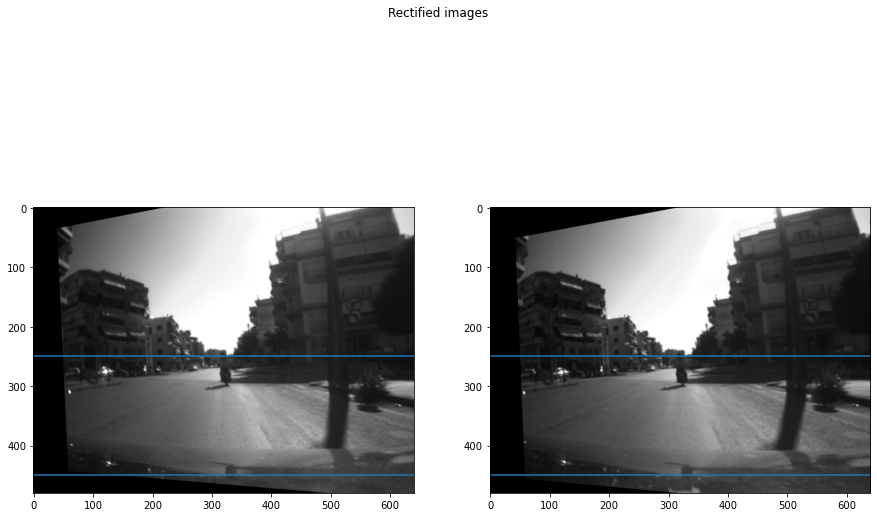

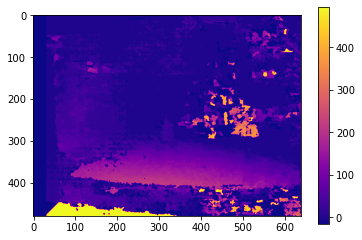

True

In [5]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
# Read both images and convert to grayscale
img1 = cv.imread('stereo_left.jpg', 0)
img2 = cv.imread('stereo_right.jpg', 0)

# ------------------------------------------------------------

# PREPROCESSING

# Compare unprocessed images
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Original images")
plt.savefig("original_images.png")
plt.show()

# 1. Detect keypoints and their descriptors


# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Visualize keypoints
imgSift = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imshow("SIFT Keypoints", imgSift)
cv.imwrite("sift_keypoints.png", imgSift)

# Match keypoints in both images//Fast Library for Approximate Nearest Neighbors

FLANN_INDEX_KDTREE =3 
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features

matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

# Draw the keypoint matches between both pictures

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)
cv.imshow("Keypoint matches", keypoint_matches)
cv.imwrite("keypoint_matches.png", keypoint_matches)


# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

# Visualize epilines



def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color

    
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.savefig("epilines.png")
plt.show()


# Stereo rectification 

h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Rectify (undistort) the images and save them

img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
cv.imwrite("rectified_1.png", img1_rectified)
cv.imwrite("rectified_2.png", img2_rectified)



# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

# ------------------------------------------------------------
# CALCULATE DISPARITY (DEPTH MAP)


# StereoSGBM Parameter explanations:


# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
block_size =3
min_disp =0
max_disp = 32
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize =50
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 1
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
    
)
disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)
cv.imshow("Disparity", disparity_SGBM)
cv.imwrite("disparity_SGBM_norm.png", disparity_SGBM)


